In [59]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import selfies as sf
from sklearn.preprocessing import LabelEncoder
from qumedl.mol.encoding.selfies_ import Selfies
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F

# dataset_name = "/home/mghazi/workspace/insilico-drug-discovery/data/KRAS_G12D/KRAS_G12D_inhibitors_451_modified.csv"
dataset_name = "/Users/mohamad/workspace/repos/Qu-MeDL/scripts/data/tiny.csv"


# Create a Selfies instance from a CSV file
selfies_instance = Selfies.from_smiles_csv(filepath=dataset_name)

# Encode the SELFIES strings
encoded_selfies = selfies_instance.encode(selfies_instance.mol_strings)

class SelfiesDataset(Dataset):
    def __init__(self, encoded_selfies):
        self.encoded_selfies = encoded_selfies

    def __len__(self):
        return len(self.encoded_selfies)

    def __getitem__(self, idx):
        src = self.encoded_selfies[idx]
        tgt = np.append(src[1:], 0)  # Shift target sequence by 1 and append pad token
        return torch.tensor(src, dtype=torch.long), torch.tensor(tgt, dtype=torch.long)

dataset = SelfiesDataset(encoded_selfies)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)


Loading Selfies From CSV: 100%|██████████| 696/696 [00:00<00:00, 1572.27it/s]


In [60]:
class TransformerGenerator(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, max_seq_length):
        super(TransformerGenerator, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = nn.Parameter(torch.zeros(1, max_seq_length, d_model))
        self.transformer = nn.Transformer(d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward)
        self.fc_out = nn.Linear(d_model, vocab_size)

    def forward(self, src, tgt):
        src_emb = self.embedding(src) + self.positional_encoding[:, :src.size(1), :]
        tgt_emb = self.embedding(tgt) + self.positional_encoding[:, :tgt.size(1), :]
        src_emb = src_emb.permute(1, 0, 2)  # Shape: (seq_len, batch_size, d_model)
        tgt_emb = tgt_emb.permute(1, 0, 2)  # Shape: (seq_len, batch_size, d_model)
        output = self.transformer(src_emb, tgt_emb)
        output = self.fc_out(output.permute(1, 0, 2))  # Shape: (batch_size, seq_len, vocab_size)
        return output
    
    def generate(self, selfies_instance, num_samples=1, max_length=100):
        self.eval()
        generated_selfies_list = []

        for _ in range(num_samples):
            # Randomly choose a start token from the vocabulary
            start_token = np.random.choice(list(selfies_instance.token_to_index.keys()))
            start_tokens = selfies_instance._encode([start_token])[0]
            src = torch.tensor(start_tokens, dtype=torch.long).unsqueeze(0)  # Add batch dimension
            tgt = torch.tensor([start_tokens[0]], dtype=torch.long).unsqueeze(0)  # Initialize target with the first token

            for _ in range(max_length):
                with torch.no_grad():
                    output = self.forward(src, tgt)
                    next_token_logits = output[:, -1, :]  # Get logits for the next token
                    next_token = torch.argmax(F.softmax(next_token_logits, dim=-1), dim=-1)
                    tgt = torch.cat((tgt, next_token.unsqueeze(0)), dim=1)

                if next_token.item() == selfies_instance.pad_index:  # Check for pad token
                    break

            generated_tokens = tgt.squeeze(0).tolist()
            generated_selfies = selfies_instance._decode(np.array([generated_tokens]), selfies_instance.pad_index)
            generated_selfies_list.append(generated_selfies[0])

        return generated_selfies_list
    
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
vocab_size = selfies_instance.n_tokens   # Size of the vocabulary
d_model = 512       # Embedding size
nhead = 8           # Number of heads in the multi-head attention
num_encoder_layers = 6
num_decoder_layers = 6
dim_feedforward = 2048
max_seq_length = selfies_instance.max_length

model = TransformerGenerator(vocab_size, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, max_seq_length)
model.to(device)

Using device: cpu


/Users/mohamad/miniconda3/envs/qcbm-ibmq/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


TransformerGenerator(
  (embedding): Embedding(34, 512)
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerDecoderLayer(


In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    for src, tgt in dataloader:
        src = src.to(device)
        tgt = tgt.to(device)
        tgt_input = tgt[:, :-1]
        tgt_output = tgt[:, 1:]

        optimizer.zero_grad()
        output = model(src, tgt_input)

        # Reshape output and tgt_output to (batch_size * seq_len, vocab_size) and (batch_size * seq_len)
        loss = criterion(output.reshape(-1, vocab_size), tgt_output.contiguous().view(-1))
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


In [53]:
num_samples = 5
new_selfies_samples = model.generate(selfies_instance, num_samples=num_samples, max_length=5)
print("Generated SELFIES samples:", new_selfies_samples)

Generated SELFIES samples: ['[N][N@H1+1][N@H1+1][N@H1+1][N@H1+1]', '[Cl][N@H1+1][N@H1+1][N@H1+1][N@H1+1]', '[#Branch1][N@H1+1][N@H1+1][N@H1+1][N@H1+1]', '[C@H1][N@H1+1][N@H1+1][N@H1+1][N@H1+1]', '[NH1][N@H1+1][N@H1+1][N@H1+1][N@H1+1]']


In [54]:
selfies_instance.selfie_to_smiles(new_selfies_samples)

['N[N@H1+1][N@H1+1][N@H1+1][N@H1+1]',
 'Cl[N@H1+1][N@H1+1][N@H1+1][N@H1+1]',
 '[N@H1+1][N@H1+1][N@H1+1][N@H1+1]',
 '[C@H1][N@H1+1][N@H1+1][N@H1+1][N@H1+1]',
 '[NH1][N@H1+1][N@H1+1][N@H1+1][N@H1+1]']

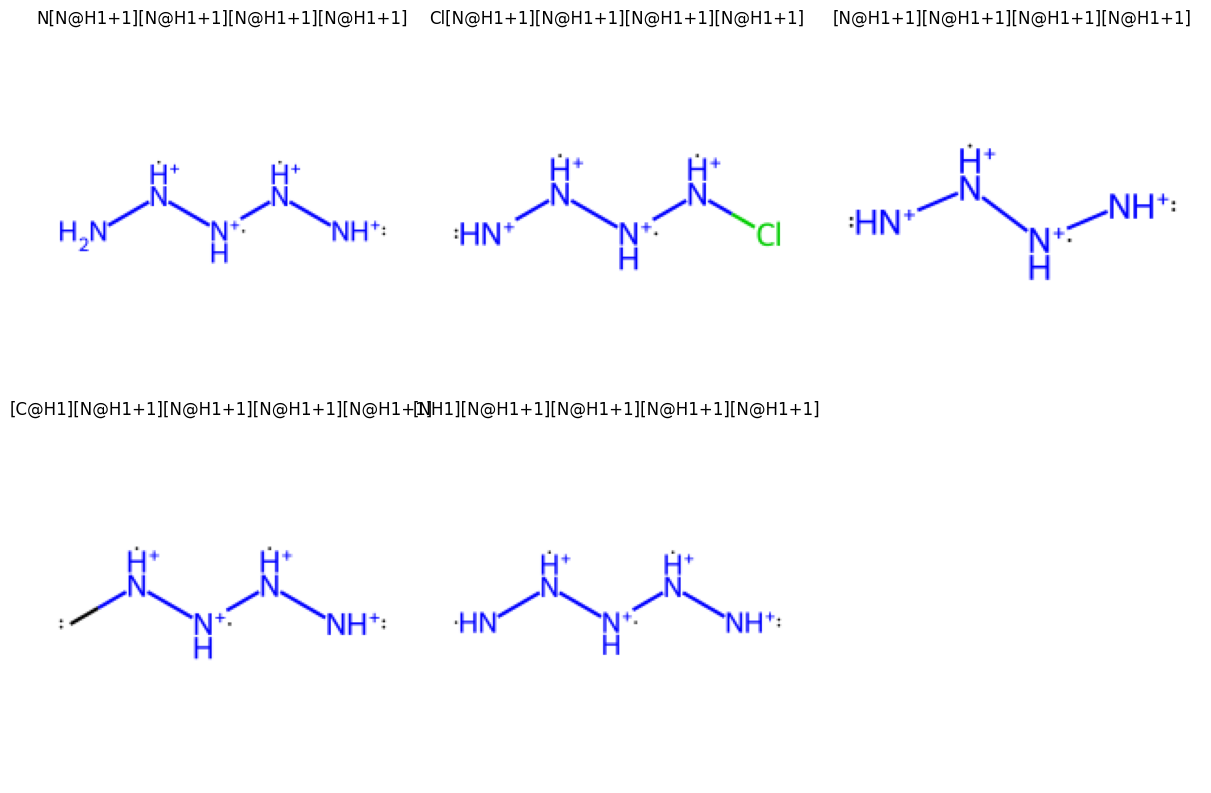

In [56]:
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from IPython.display import display
import matplotlib.pyplot as plt

def draw_smiles(smiles_list, n_col=3):
    mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
    for mol in mols:
        AllChem.Compute2DCoords(mol)
    
    n_row = (len(smiles_list) + n_col - 1) // n_col  # Calculate number of rows needed
    fig, axes = plt.subplots(n_row, n_col, figsize=(n_col*4, n_row*4))
    axes = axes.flatten()
    
    for i, mol in enumerate(mols):
        if mol is not None:
            img = Draw.MolToImage(mol, size=(200, 200))
            axes[i].imshow(img)
            axes[i].axis('off')
            axes[i].set_title(smiles_list[i])
        else:
            axes[i].axis('off')
    
    # Hide any remaining axes
    for j in range(i+1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Draw the generated SMILES samples
draw_smiles(selfies_instance.selfie_to_smiles(new_selfies_samples))
